## Challenge MDI343 : Sparse Score Fusion for Classifying Mate Pairs of Images

## Chapter 1. Data loading and function definition

In [1]:
# Imported package are as follows:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from scipy.optimize import minimize

In [2]:
# Running time of each algorithm (in milliseconds)

alg_times = np.zeros((14, 1))
alg_times[0] = 163
alg_times[1] = 163
alg_times[2] = 190
alg_times[3] = 190
alg_times[4] = 206
alg_times[5] = 206
alg_times[6] = 120
alg_times[7] = 120
alg_times[8] = 83
alg_times[9] = 83
alg_times[10] = 83
alg_times[11] = 83
alg_times[12] = 170
alg_times[13] = 170

# Time constraint: The total duration of the algorithms cannot exceed 600 milliseconds
alg_time_thr = 600


# Compute the total computational time for the fusion algorithm
def compute_total_time(M):
    is_used = np.zeros((14, 1))
    for i in range(15):
        for j in range(15):
            if(M[i, j] != 0):
                if(i >= 1):
                    is_used[i - 1] = 1
                if(j >= 1):
                    is_used[j - 1] = 1

    total_dur = np.dot(is_used.T, alg_times)
    return total_dur[0, 0]

# Evaluation metric


def compute_eval(fused_score):
    look_at_FAR = 0.0001
    # calculating FAR and FRR
    sort = np.argsort(fused_score[:, 1])

    #sort = np.concatenate([sort[-2:],sort[:-2]], axis=0)
    scores = fused_score[sort]
    totpos = sum(scores[:, 0])
    totneg = scores.shape[0] - totpos
    fa = (np.cumsum(scores[:, 0] - 1) + totneg) / totneg
    fr = np.cumsum(scores[:, 0]) / totpos

    i = 0
    while fa[i] > look_at_FAR:
        i += 1

    return scores[i][1], fa[i], fr[i]

In [60]:
# Load the data

train_fname = 'train15_telecom.txt'
train_data = np.loadtxt(train_fname, dtype=np.float)
# The first column contains the labels, the rest of the columns contains the scores

# Extract the labels
y_trn = train_data[:, 0].astype(int)

# Extract the score vectors
s_trn = train_data.copy()
s_trn[:, 0] = 1;

# Assign the training dataset and corresponding labels
X, y = s_trn, y_trn
X[X == -float("inf")] = 0

## Chapter 2. Feature analysis and comparision

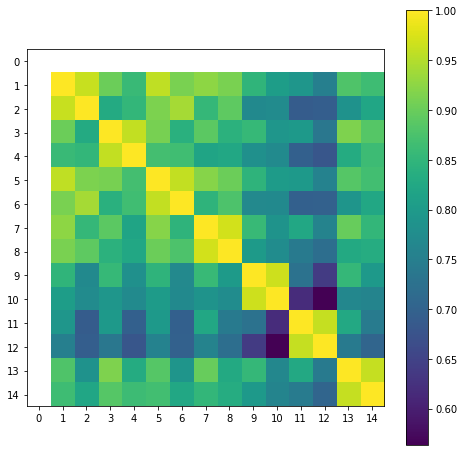

In [91]:
# Calculate and visualize the correlation among algorithms
corr = pd.DataFrame(X).corr()
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)

#### It is seen that these pair algorithms are reletively corelated: Algo1 and 2, Algo3 and 4, algo5 and 6, Algo7 and 8, Algo9 and 10, Algo11 and 12, Algo13 and 14. That is possible due to these pair algorithms have used similar evaluation method. Thus for constructing a better combinason amaong all those algorithme, it would be better to use only one of the corelated algorithm pair as mentioned before.

In [59]:
# Feature importance analysis by logistic regression
lr = LogisticRegression()
lr.fit(X, y)
importances = abs(np.std(X, 0) * lr.coef_)
importances = [float(i) / sum(importances[0]) for i in importances[0]]
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 13 (0.146765)
2. feature 7 (0.138985)
3. feature 8 (0.121416)
4. feature 14 (0.105819)
5. feature 2 (0.093915)
6. feature 1 (0.091977)
7. feature 3 (0.072960)
8. feature 6 (0.071967)
9. feature 5 (0.058427)
10. feature 4 (0.045028)
11. feature 12 (0.026641)
12. feature 9 (0.015857)
13. feature 11 (0.009708)
14. feature 10 (0.000534)
15. feature 0 (0.000000)


In [ ]:
importances = np.array(importances)
plt.figure(figsize=(12,8)) 
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],color="b", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [101]:
# Feature importance analysis  by ensemble learning
forest = ExtraTreesClassifier()
forest.fit(X, y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 8 (0.168697)
2. feature 13 (0.160891)
3. feature 12 (0.114658)
4. feature 9 (0.113258)
5. feature 14 (0.108318)
6. feature 3 (0.082350)
7. feature 7 (0.067076)
8. feature 5 (0.054746)
9. feature 11 (0.053710)
10. feature 1 (0.033715)
11. feature 10 (0.015786)
12. feature 2 (0.015317)
13. feature 4 (0.006275)
14. feature 6 (0.005204)
15. feature 0 (0.000000)


In [ ]:
plt.figure(figsize=(12,8)) 
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

#### Results of feature importance analysis by logistic regression and extra tree are not exactly the same. But in global, il it found that the algo 7, 8, 13, 14 are relitively having more weigh than other algorithms.

In [577]:
# Test the performance of each algorithm.

for i in range(1, 15):
    M = np.zeros((15, 15))
    M[0, i] = 1
    fuse = np.multiply(s_trn[:, None, :] * s_trn[:, :, None], M)
    fuse = np.concatenate([np.reshape(
        y_trn, [-1, 1]), np.reshape(np.sum(fuse, axis=(1, 2)), [-1, 1])], axis=1)
    fuse[np.isnan(fuse)] = -float("inf")

    # compute the FRR at FAR = 0.01%
    thr, fa, fr = compute_eval(fuse)
    look_at_FAR = 0.0001
    print("if only algorithm", i, ":, threshold :",
          thr, "far :", fa, "frr :", fr)

if only algorithm 1 :, threshold : 5023.26 far : 9.9610468009e-05 frr : 0.253079046817
if only algorithm 2 :, threshold : 5029.01 far : 9.9610468009e-05 frr : 0.253079046817
if only algorithm 3 :, threshold : 5028.1 far : 9.9610468009e-05 frr : 0.255898650898
if only algorithm 4 :, threshold : 5032.16 far : 9.9610468009e-05 frr : 0.255898650898
if only algorithm 5 :, threshold : 4906.89 far : 9.9610468009e-05 frr : 0.231109631689
if only algorithm 6 :, threshold : 4952.24 far : 9.9610468009e-05 frr : 0.231109631689
if only algorithm 7 :, threshold : 5002.08 far : 9.9610468009e-05 frr : 0.165397192144
if only algorithm 8 :, threshold : 5015.17 far : 9.9610468009e-05 frr : 0.165397192144
if only algorithm 9 :, threshold : 4659.33 far : 9.9610468009e-05 frr : 0.174090971393
if only algorithm 10 :, threshold : 4782.7 far : 9.9610468009e-05 frr : 0.174090971393
if only algorithm 11 :, threshold : 4949.0 far : 9.9610468009e-05 frr : 0.313034794698
if only algorithm 12 :, threshold : 4980.23 

#### This result corresponds well with the former correlation analysis among features. The errors "frr" are almost the same for each pair algorithm, ie Algo1 and 2, ... ,Algo13 and 14. What's more, it shows that Algo 7, 8, 9, 10, 13, 14 display better performance, this is also consistent with the conclusion from feature importance anamysis.

## Chapter 3. Variable construction and processing

In [579]:
# Calculate how much possible combinations among 14 algorithms
comb = [[True], [False]]
for i in range(14 - 1):
    comb_tmp = []
    for j in range(len(comb)):
        comb_tmp += [comb[j] + [True], comb[j] + [False]]
    comb = comb_tmp
print('Possible combinations : ', len(comb))  # (16384 combinations)

# Create a dataframe with all possible combinations

df = pd.DataFrame(data=comb, columns=['alg1', 'alg2', 'alg3', 'alg4', 'alg5',
                                      'alg6', 'alg7', 'alg8', 'alg9', 'alg10', 'alg11', 'alg12', 'alg13', 'alg14'])
df = df * 1
df["time"] = np.dot(df, alg_times)

# Remove the combinations that exceed duration 600 milliseconds

df = df[df["time"] <= 600]  # (1024 combinations)
df = df.reset_index(drop=True)
df.head()

Possible combinations :  16384


,alg1,alg2,alg3,alg4,alg5,alg6,alg7,alg8,alg9,alg10,alg11,alg12,alg13,alg14,time
0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,599
1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,599
2,1,1,1,0,0,0,0,0,0,0,1,0,0,0,599
3,1,1,1,0,0,0,0,0,0,0,0,1,0,0,599
4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,516


In [583]:
# Find the combinations which have been included in other combinaton.
# That is to say, find subsets among those combination

comb_to_red = []
for i in range(df.shape[0]):
    for j in range(df.shape[0]):
        if i != j:
            if (df.iloc[i, :14] >= df.iloc[j, :14]).all():
                comb_to_red.append(j)
comb_to_red = np.unique(comb_to_red)

list(comb_to_red)
df = df.drop(comb_to_red)
df = df.reset_index(drop=True)

# df.shape = (577, 15), now we have reduced possible combinations from 1204 to 577

In [623]:
# Calculate error "frr" for each combinations in dataframe df
# The coefficent for these combinations are simply identificly given, ie 1

df["error"] = 0
for i in range(df.shape[0]):
    M = np.zeros((15, 15))
    M[0, 1:] = df.iloc[i][:14]
    fuse = np.multiply(s_trn[:, None, :] * s_trn[:, :, None], M)
    fuse = np.concatenate([np.reshape(
        y_trn, [-1, 1]), np.reshape(np.sum(fuse, axis=(1, 2)), [-1, 1])], axis=1)
    fuse[np.isnan(fuse)] = -float("inf")

    # compute the FRR at FAR = 0.01%
    thr, fa, fr = compute_eval(fuse)
    # print(i, fr)
    df["error"][i] = fr


#### Then the intersting algorithm combinations are filtered according their error "frr", those with 10 least errors are selected. They will be applied an optimization function to find the best coefficients.

In [625]:
df_selected = df.sort_values(by=['error'])[:10]
df_refined = df_selected.copy()

## Chapter 4: Optimization of combination coefficients

In [450]:
# The function which minimize the error "frr"
def combcoef(coef):

    M = np.zeros((15, 15))
    M[0, index[0]] = coef[0]
    M[0, index[1]] = coef[0]
    M[0, index[2]] = coef[1]
    M[0, index[3]] = coef[2]
    M[0, index[4]] = coef[3]

    look_at_FAR = 0.0001
    # calculating FAR and FRR
    fuse = np.multiply(s_trn[:, None, :] * s_trn[:, :, None], M)
    fuse = np.concatenate([np.reshape(
        y_trn, [-1, 1]), np.reshape(np.sum(fuse, axis=(1, 2)), [-1, 1])], axis=1)
    fuse[np.isnan(fuse)] = -float("inf")
    sort = np.argsort(fuse[:, 1])

    #sort = np.concatenate([sort[-2:],sort[:-2]], axis=0)
    scores = fuse[sort]
    totpos = sum(scores[:, 0])
    totneg = scores.shape[0] - totpos
    fa = (np.cumsum(scores[:, 0] - 1) + totneg) / totneg
    fr = np.cumsum(scores[:, 0]) / totpos

    i = 0
    while fa[i] > look_at_FAR:
        i += 1
    # print(fr[i])
    return fr[i]

In [624]:
# Run the optimization function to find the best coefficent to each potential combination

coef_list = []
for comb in range(df_refined.shape[0]):
    coef0 = [1, 1, 1, 1, 1]
    index = []
    for alg in range(14):
        if df_refined.iloc[comb, alg] != 0:
            index.append(alg + 1)
    # print(index)
    # print(df_refined.iloc[comb, :14], ":")
    res = minimize(combcoef, coef0, args=(), method="COBYLA",
                   jac=None, hess=None, hessp=None, tol=None, callback=None)
    # print(res.x)
    coef_list.append(res.x)


In [626]:
# Collect optimized coefficients into dataframe

for comb in range(df_refined.shape[0]):
    ind = 0
    for alg in range(14):
        if df_refined.iloc[comb, alg] != 0:
            df_refined.iloc[comb, alg] = coef_list[comb][ind]
            ind = ind + 1

## Chapter 5: Validation and conclusion

In [622]:
# Calculate error "frr" with those optimized cofficients for training data

M_refined_all = []
for i in range(df_refined.shape[0]):
    M = np.zeros((15, 15))
    M[0, 1:] = df_refined.iloc[i][:14]
    M_refined_all.append(M)

    fuse = np.multiply(s_trn[:, None, :] * s_trn[:, :, None], M)
    fuse = np.concatenate([np.reshape(
        y_trn, [-1, 1]), np.reshape(np.sum(fuse, axis=(1, 2)), [-1, 1])], axis=1)
    fuse[np.isnan(fuse)] = -float("inf")

    # compute the FRR at FAR = 0.01%
    thr, fa, fr = compute_eval(fuse)
    df_refined.iloc[i, 15] = fr
    # print("for comb",i+1,":", "fr =", fr)

df_refined = df_refined.reset_index(drop=True)
df_refined.sort_values(by="error")

,alg1,alg2,alg3,alg4,alg5,alg6,alg7,alg8,alg9,alg10,alg11,alg12,alg13,alg14,time,error
0,0,0,0,0,0,0,0,0.97863,0.92145,1.01491,0.992821,0,0,0.906982,539,0.082473
1,0,0,0,0,0,0,0.633101,0,0.641464,0.742667,0.814128,0,1,0,539,0.083198
4,0,0,0,0,0,0,0.562156,0,0.599002,1.03809,0,0.905884,0,0.984055,539,0.083629
7,0,0,0,0,0,0,0,1.48445,1.02796,2.02084,0,1.99793,0,0.996331,539,0.083648
3,0,0,0,0,0,0,0.851942,0,1.02801,1.19234,0.926618,0,0,1,539,0.083766
9,0,0,0,0,0,0,0.79514,2.28029,2.08815,0,1.30657,0,1.02888,0,576,0.084921
5,0,0,0,0,0,0,1.00705,0,0.993355,1.85703,0,1.17096,1,0,539,0.086527
8,0,0,0,0,0,0,0.750372,2.21014,1.55685,0,1.40503,0,0,0.99457,576,0.087388
6,0,0,0,0,0,0,0,1.43542,1.23062,1.95381,0,0.957369,1,0,539,0.089640
2,0,0,0,0,0,0,0,0.533291,0.429814,0.52981,0.355249,0,0.956879,0,539,0.090932


#### Those coefficients are generally validated for training data, except the combination 3, ie combination among Algo 8, 9, 10, 11, 13. 

In [618]:
# Submission

# Write the matrix M to the disk:

for M in range(len(M_refined_all)):
    np.savetxt('M_pred_' + str(M + 1) + '.txt', M_refined_all[M], fmt='%f')

# M_pred_1.txt => 0.0710172744722
# M_pred_2.txt => 0.0753358925144
# M_pred_3.txt => 0.0830134357006
# M_pred_4.txt => 0.0681381957774
# M_pred_5.txt => 0.0714971209213
# M_pred_6.txt => 0.0690978886756
# M_pred_7.txt => 0.0700575815739
# M_pred_8.txt => 0.0724568138196
# M_pred_9.txt => 0.0748560460653
# M_pred_10.txt => 0.0734165067179

#### The validation for test data are mainly consistent to the result from training data. Algorithm combination 3 displays the worst classification among the 10 selected combinations. The others are a little homogenous, but in termes of test validation, the combination 4, composed of Algo 7, 9, 10, 11, 14 has the best classification performance.

#### Through this challenge, we can see the advantage that confusion matrix methods offers better target detection performance. Compared with one best algorithm, ie Algo 7 or 8, which gives frr around 0.1653, finaly we reached the frr to about 0.0681, where over the half of frr has been reduced by comfusion method. 